In [1]:
%load_ext autoreload
%autoreload 2

In [14]:
import pickle
import numpy as np
from import_casa import casa
from casa import caprice

In [3]:
with open("../../../data/caprice/caprice_seq_data_20210430.pkl", "rb") as fin:
    data = pickle.load(fin)

In [4]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
model_path = "../../../data/caprice/seq-model-ep9"
tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForSequenceClassification.from_pretrained(model_path)

In [5]:
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "Microsoft JhengHei"

In [6]:
import shap

In [7]:
from transformers import pipeline
caprice_pipeline = pipeline('sentiment-analysis', model=model, tokenizer=tokenizer)

In [8]:
explainer = shap.Explainer(caprice_pipeline, algorithm="partition")

In [9]:
_masker = explainer.masker

In [10]:
import torch
from DistilTag import DistilTag
tagger = DistilTag()

In [11]:
tagger.tag("我才不要去辦吃到飽")

[[('我', 'Nh'),
  ('才', 'Da'),
  ('不要', 'D'),
  ('去', 'D'),
  ('辦', 'VC'),
  ('吃', 'VC'),
  ('到', 'P'),
  ('飽', 'VH')]]

In [15]:
from types import MethodType
from functools import partial
from scipy.cluster.hierarchy import to_tree, dendrogram
txt = "他貴到一個爆炸"

clustering_wrapper = partial(caprice.custom_clustering, pat="", tagger_inst=tagger)
explainer.masker.clustering = MethodType(clustering_wrapper, explainer.masker)
shap_values = explainer([txt], fixed_context=0)

In [17]:
Z = shap_values.clustering[0]

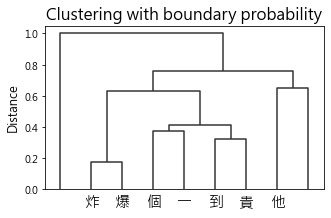

In [34]:
dendrogram(Z, labels=_masker._segments_s, link_color_func=lambda k: "#333333");
plt.gca().tick_params(axis='x', which='major', labelsize=15)
plt.ylabel("Distance", fontsize=12)
plt.title("Clustering with boundary probability", fontsize=16)
plt.gcf().set_size_inches((5,3))
plt.savefig("word_clustering.png", dpi=150)

In [110]:
from types import MethodType
from functools import partial
clustering_wrapper = partial(custom_clustering, pat="(到一個)")
explainer.masker.clustering = MethodType(clustering_wrapper, explainer.masker)

In [111]:
shap_values = explainer(["他貴到一個爆炸"])

In [114]:
shap_values.clustering

array([[[ 4.        ,  5.        ,  0.12327712,  2.        ],
        [ 3.        ,  9.        ,  0.1359199 ,  3.        ],
        [ 6.        ,  7.        ,  0.17089015,  2.        ],
        [ 2.        , 10.        ,  0.3227866 ,  4.        ],
        [11.        , 12.        ,  0.63041621,  6.        ],
        [ 0.        ,  1.        ,  0.64684439,  2.        ],
        [13.        , 14.        ,  0.75969934,  8.        ],
        [ 8.        , 15.        ,  1.        ,  9.        ]]])

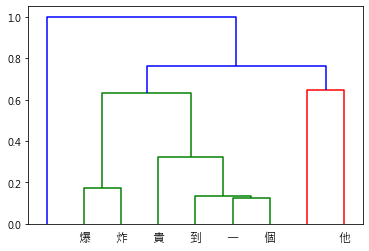

In [115]:
dendrogram(shap_values.clustering[0], labels=_masker._segments_s);

In [112]:
shap.plots.text(shap_values[0, :, 1])

In [35]:
tagger.print_soft_tag(*tagger.soft_tag(txt))

他_0.58  Nh_0.50/ VH_0.04/SPC_0.03/V_2_0.02/ Nb_0.02
貴_0.64  VH_0.50/ VC_0.04/ VJ_0.04/Dfa_0.02/ VA_0.02
到_0.41  VH_0.15/VCL_0.12/ VJ_0.10/ VC_0.06/Caa_0.05
一_0.45 Neu_0.53/ VH_0.05/ Nb_0.02/ Nd_0.02/Cbb_0.02
個_0.43  Nf_0.37/ VH_0.05/ Nc_0.04/ Na_0.03/ Nd_0.03
爆_0.57  VH_0.32/ Nv_0.27/ Na_0.14/ VC_0.05/ VA_0.02
炸_0.31  VH_0.30/ Nv_0.28/ Na_0.12/ VC_0.08/ VA_0.02



## Fluid DistilSeg

In [1]:
%load_ext autoreload
%autoreload 2

In [9]:
import DistilTag
import numpy as np

In [2]:
tagger = DistilTag.DistilTag()

In [3]:
txt = "消失在人海盡頭"
out = tagger.tag(txt, return_logits=True)
logits = out[1]
tokens = out[2]
out[0]

[[('消失', 'VA'), ('在', 'P'), ('人海', 'Na'), ('盡頭', 'Ncd')]]

In [4]:
out = tagger.soft_tag(txt)

In [5]:
tagger.print_soft_tag(*out, Tw=2, Tp=2)

消_0.60  VA_0.57/ VH_0.04/ Na_0.02/ Nv_0.02/ Nd_0.02
失_0.35  VA_0.54/VAC_0.03/ Na_0.03/ VH_0.03/ Nv_0.02
在_0.52 VCL_0.20/  P_0.07/ VG_0.05/Caa_0.04/ VJ_0.03
人_0.60  Na_0.30/ Nc_0.25/ Nb_0.05/ VH_0.04/ Nh_0.03
海_0.38  Na_0.71/ Nc_0.12/ VH_0.03/ Nb_0.02/ VA_0.01
盡_0.49 Ncd_0.61/ Nc_0.06/ Ng_0.03/Nep_0.02/ VH_0.01
頭_0.40 Ncd_0.63/ Nc_0.04/ Ng_0.02/ Na_0.01/Neq_0.01



In [10]:
print("0.50", tagger.decode_soft_tag(*out, Tw=1, Tp=1, wcut=0.5))

0.50 [[('消失', 'VA'), ('在', 'VCL'), ('人海盡頭', 'Ncd')]]


In [11]:
for wcut in np.arange(0, 1, 0.1):
    print(f"{wcut:.2f}", tagger.decode_soft_tag(*out, Tw=2, Tp=1, wcut=wcut))

0.00 [[('消', 'VA'), ('失', 'VA'), ('在', 'VCL'), ('人', 'Na'), ('海', 'Na'), ('盡', 'Ncd'), ('頭', 'Ncd')]]
0.10 [[('消', 'VA'), ('失', 'VA'), ('在', 'VCL'), ('人', 'Na'), ('海', 'Na'), ('盡', 'Ncd'), ('頭', 'Ncd')]]
0.20 [[('消', 'VA'), ('失', 'VA'), ('在', 'VCL'), ('人', 'Na'), ('海', 'Na'), ('盡', 'Ncd'), ('頭', 'Ncd')]]
0.30 [[('消', 'VA'), ('失', 'VA'), ('在', 'VCL'), ('人', 'Na'), ('海', 'Na'), ('盡', 'Ncd'), ('頭', 'Ncd')]]
0.40 [[('消失', 'VA'), ('在', 'VCL'), ('人海', 'Na'), ('盡', 'Ncd'), ('頭', 'Ncd')]]
0.50 [[('消失', 'VA'), ('在', 'VCL'), ('人海盡頭', 'Ncd')]]
0.60 [[('消失在', 'VA'), ('人海盡頭', 'Ncd')]]
0.70 [[('消失在人海盡頭', 'Ncd')]]
0.80 [[('消失在人海盡頭', 'Ncd')]]
0.90 [[('消失在人海盡頭', 'Ncd')]]


In [12]:
for wcut in np.arange(0, 1, 0.1):
    print(f"{wcut:.2f}", tagger.decode_soft_tag(*out, Tw=1, Tp=5, wcut=wcut))

0.00 [[('消', 'VA'), ('失', 'VA'), ('在', 'VCL'), ('人', 'Na'), ('海', 'Na'), ('盡', 'Ncd'), ('頭', 'Ncd')]]
0.10 [[('消', 'VA'), ('失', 'VA'), ('在', 'VCL'), ('人', 'Na'), ('海', 'Na'), ('盡', 'Ncd'), ('頭', 'Ncd')]]
0.20 [[('消', 'VA'), ('失', 'VA'), ('在', 'VCL'), ('人', 'Na'), ('海', 'Na'), ('盡', 'Ncd'), ('頭', 'Ncd')]]
0.30 [[('消失', 'VA'), ('在', 'VCL'), ('人海', 'Na'), ('盡', 'Ncd'), ('頭', 'Ncd')]]
0.40 [[('消失', 'VA'), ('在', 'VCL'), ('人海', 'Na'), ('盡頭', 'Ncd')]]
0.50 [[('消失', 'VA'), ('在', 'VCL'), ('人海盡頭', 'Na')]]
0.60 [[('消失在', 'VA'), ('人海盡頭', 'Na')]]
0.70 [[('消失在人海盡頭', 'Na')]]
0.80 [[('消失在人海盡頭', 'Na')]]
0.90 [[('消失在人海盡頭', 'Na')]]
